# 🧠 Alzheimer's Disease Classification

🕸️ A Convolutional Neural Network (CNN) model is used here to classify brain MRIs into normal, very-mild, mild and moderate Alzheimer classes. The data in total consists of 6400 images.

Developed as part of a project work for the **UCS 1603 Introduction to Machine Learning** Course. 📖

Authors:
* Shashanka Venkatesh  - 18 5001 145
* Suraj Jain           - 18 5001 177
* Vishakan Subramanian - 18 5001 196
* Vishnu Krishnan      - 18 5001 200

**We recommend the use of a GPU Accelerator to reduce the load on the CPU and to run the notebook faster.**

### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG


import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.10.0


C:\Users\ghlis\anaconda3.1\envs\deeplearning\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\ghlis\anaconda3.1\envs\deeplearning\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

### Data Pre-Processing

In [2]:
base_dir = 'AD_data/3-splitted_ADNI(6400)/Alzheimer_s Dataset/'
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=1000, shuffle=False)

Found 6400 images belonging to 4 classes.


In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    

In [6]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [7]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(1000, 176, 176, 3) (1000, 4)


In [37]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(738, 176, 176, 3) (738, 3)


In [8]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Constructing a Convolutional Neural Network Architecture

In [9]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [10]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [11]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [12]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [13]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

### Training & Testing the Model

In [14]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
20/20 [==============================] - 4s 109ms/step - loss: 2.0260 - acc: 0.2656 - auc: 0.5065 - f1_score: 0.1447 - val_loss: 1.3501 - val_acc: 0.1688 - val_auc: 0.6029 - val_f1_score: 0.0874
Epoch 2/100
20/20 [==============================] - 1s 69ms/step - loss: 1.7089 - acc: 0.3234 - auc: 0.5777 - f1_score: 0.1679 - val_loss: 1.3587 - val_acc: 0.0563 - val_auc: 0.6038 - val_f1_score: 0.0706
Epoch 3/100
20/20 [==============================] - 1s 63ms/step - loss: 1.4720 - acc: 0.4219 - auc: 0.6517 - f1_score: 0.2106 - val_loss: 0.7858 - val_acc: 0.9062 - val_auc: 0.9404 - val_f1_score: 0.2377
Epoch 4/100
20/20 [==============================] - 1s 64ms/step - loss: 1.3433 - acc: 0.4734 - auc: 0.6975 - f1_score: 0.2276 - val_loss: 0.5634 - val_acc: 0.9062 - val_auc: 0.9427 - val_f1_score: 0.2377
Epoch 5/100
20/20 [==============================] - 1s 63ms/step - loss: 1.1753 - acc: 0.5250 - auc: 0.7636 - f1_score: 0.2404 - val_loss: 0.6924 - val_acc: 0.9062 - val_auc:

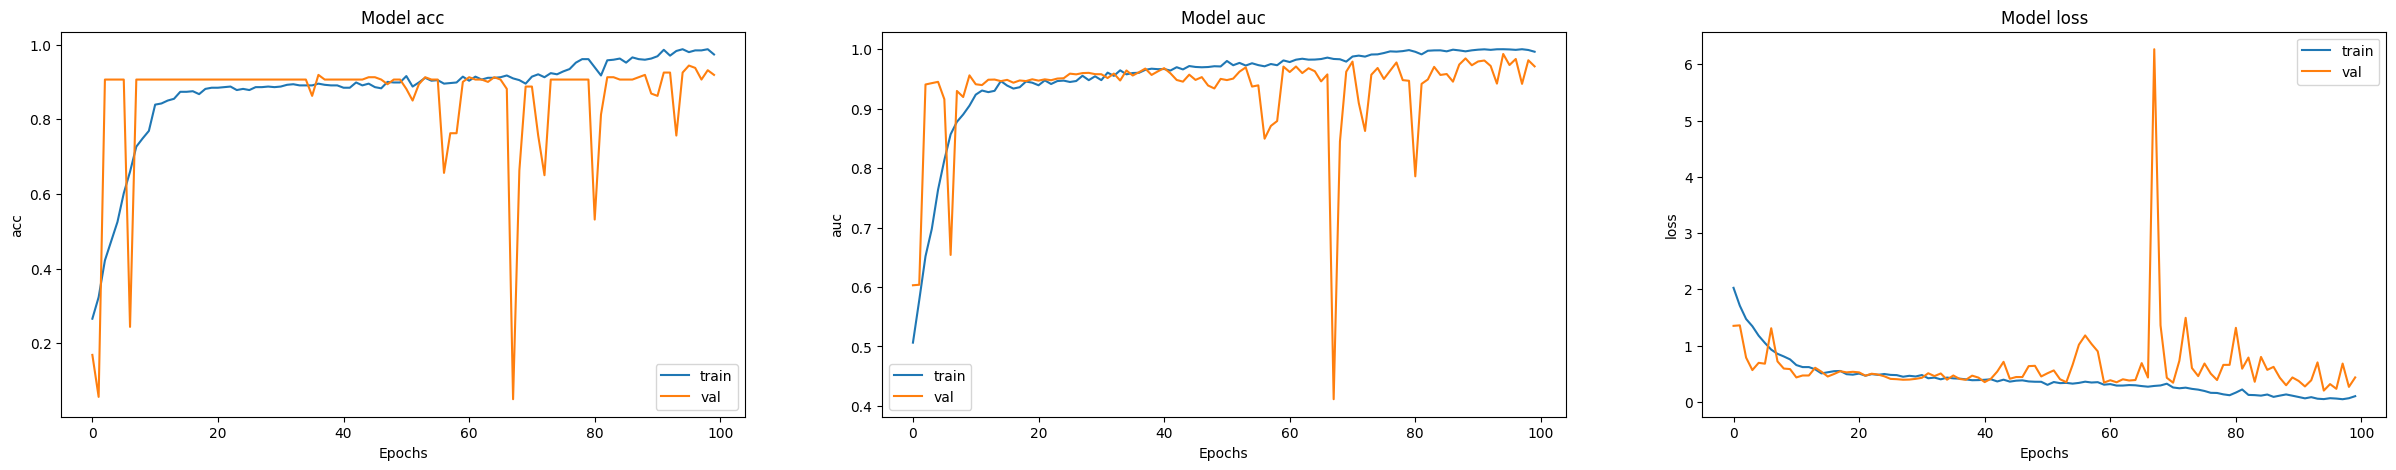

In [15]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [16]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

7/7 [==============================] - 1s 57ms/step - loss: 0.4653 - acc: 0.9050 - auc: 0.9725 - f1_score: 0.3540
Testing Accuracy: 90.50%


In [17]:
#Predicting the test data

pred_labels = model.predict(test_data)

7/7 [==============================] - 1s 48ms/step


In [18]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.90      1.00      0.95       178
VeryMildDemented       1.00      0.15      0.27        13
    MildDemented       1.00      0.11      0.20         9
ModerateDemented       0.00      0.00      0.00         0

       micro avg       0.91      0.91      0.91       200
       macro avg       0.73      0.32      0.35       200
    weighted avg       0.91      0.91      0.87       200
     samples avg       0.91      0.91      0.91       200



C:\Users\ghlis\anaconda3.1\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghlis\anaconda3.1\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import precision_recall_fscore_support

test_scores = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)

# Calculate precision, recall, and F2 score
precision, recall, f2_score, _ = precision_recall_fscore_support(test_labels.argmax(axis=1), predictions.argmax(axis=1), average='weighted', beta=2)

print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F2 Score: %.2f" % f2_score)


7/7 [==============================] - 0s 58ms/step
Testing Accuracy: 90.50%
Precision: 0.91
Recall: 0.91
F2 Score: 0.89


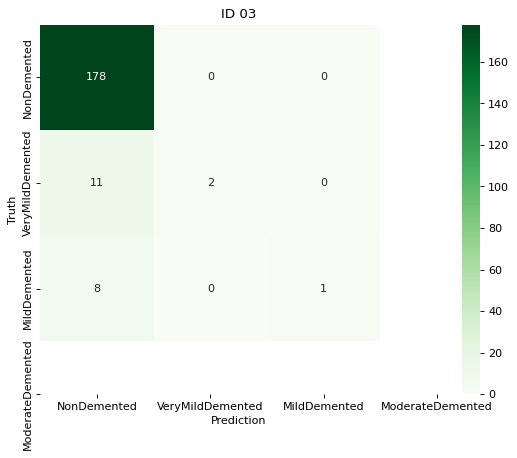

In [20]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('ID 03')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [21]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 42.17 %
Matthew's Correlation Coefficient: 35.53 %


In [22]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [ ]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

### Using the InceptionV3 model as a base model for the task

**Please check out the notebook here: 
[Inception V3 Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-inceptionv3)**

In [26]:
model.save('models/id3_adni_.h5')


In [38]:
# Assume 'new_data_dir' is the directory where you upload the new data
new_data_dir = 'AD_data/2-OASIS(9488)/input'

# Preprocess the new data
new_data_generator = work_dr.flow_from_directory(directory=new_data_dir, target_size=DIM, batch_size=1000, shuffle=False)
new_data, new_labels = new_data_generator.next()
new_data = new_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Make predictions with the model
new_predictions = model.predict(new_data)

# Optionally, you can decode the predictions if you have a mapping of class indices to class labels
decoded_predictions = [CLASSES[np.argmax(pred)] for pred in new_predictions]



Found 9488 images belonging to 4 classes.
32/32 [==============================] - 2s 60ms/step


In [39]:

# Evaluate the model on the new data
new_scores = model.evaluate(new_data, new_labels)

# Print the testing accuracy
print("Testing Accuracy on New Data: %.2f%%" % (new_scores[1] * 100))

32/32 [==============================] - 2s 76ms/step - loss: 0.4663 - acc: 0.8840 - auc: 0.9732 - f1_score: 0.2346
Testing Accuracy on New Data: 88.40%


In [41]:
from tensorflow.keras.models import load_model
id3 = load_model("models/id3_adni_.h5")

In [42]:

new_scores = id3.evaluate(new_data, new_labels)

# Print the testing accuracy
print("Testing Accuracy on New Data: %.2f%%" % (new_scores[1] * 100))

32/32 [==============================] - 3s 73ms/step - loss: 0.4663 - acc: 0.8840 - auc: 0.9732 - f1_score: 0.2346
Testing Accuracy on New Data: 88.40%
